## Calculating displacement due to faulting

This notebook will calculate _displacement_ at specified points due to slip on a fault. 

In [ ]:
# Import libraries
import pandas as pd
import numpy as np # Numerical analysis
import gmsh # Creation of fault models
import meshio # Interaction between fault model files and Python
import matplotlib.pyplot as plt # Visualize 
from pyproj import Proj
import pyproj
import h5py
%matplotlib widget

In [ ]:
# Define some basic coordinate transformation functions
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return azimuth, elevation, r

def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon

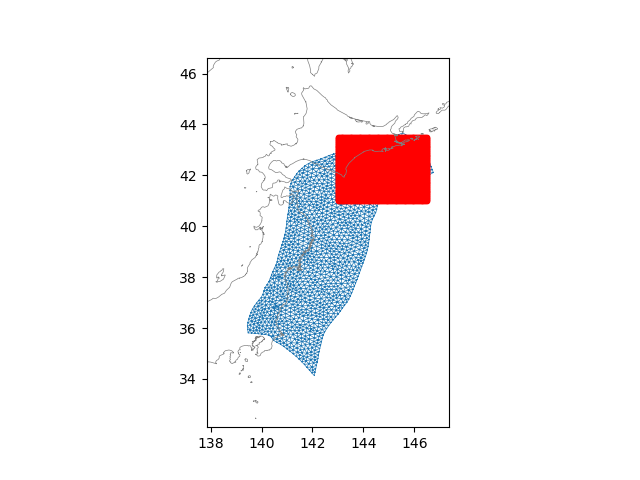

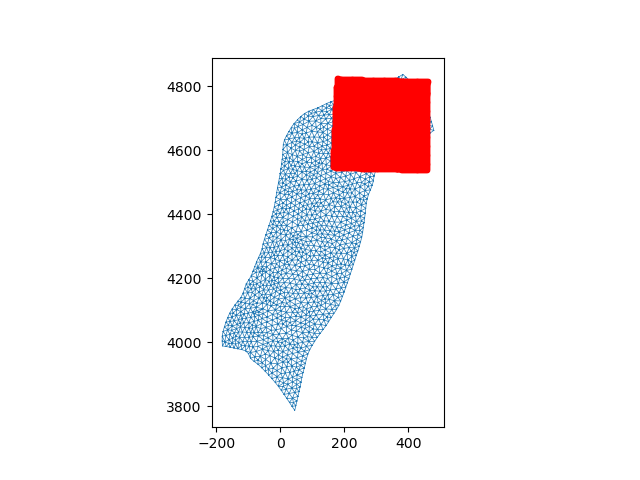

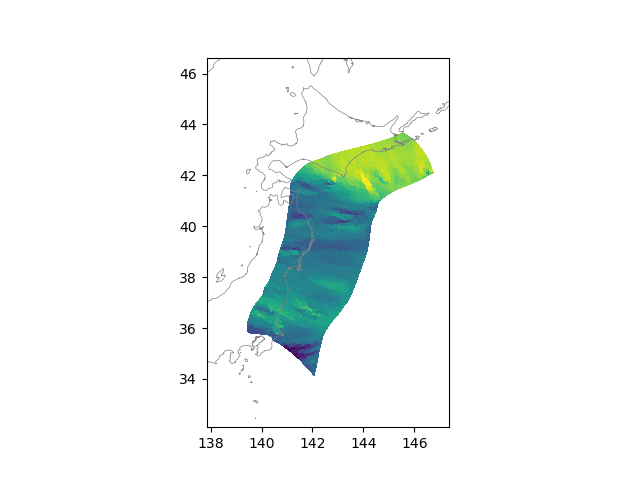

In [2]:
# Read in source fault
filename = "cascadia.msh"
# filename = "japan.msh"
mesh = dict()
meshobj = meshio.read(filename)
mesh["file_name"] = filename
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

# Expand mesh coordinates
mesh["lon1"] = mesh["points"][mesh["verts"][:, 0], 0]
mesh["lon2"] = mesh["points"][mesh["verts"][:, 1], 0]
mesh["lon3"] = mesh["points"][mesh["verts"][:, 2], 0]
mesh["lat1"] = mesh["points"][mesh["verts"][:, 0], 1]
mesh["lat2"] = mesh["points"][mesh["verts"][:, 1], 1]
mesh["lat3"] = mesh["points"][mesh["verts"][:, 2], 1]
mesh["dep1"] = mesh["points"][mesh["verts"][:, 0], 2]
mesh["dep2"] = mesh["points"][mesh["verts"][:, 1], 2]
mesh["dep3"] = mesh["points"][mesh["verts"][:, 2], 2]
mesh["centroids"] = np.mean(mesh["points"][mesh["verts"], :], axis=1)

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(mesh["lon2"] - mesh["lon1"]), np.deg2rad(mesh["lat2"] - mesh["lat1"]), (1 + KM2M * mesh["dep2"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(mesh["lon3"] - mesh["lon1"]), np.deg2rad(mesh["lat3"] - mesh["lat1"]), (1 + KM2M * mesh["dep3"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
mesh["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(mesh["nv"][:, 0], mesh["nv"][:, 1], mesh["nv"][:, 2])
mesh["strike"] = wrap2360(-np.rad2deg(azimuth))
mesh["dip"] = 90 - np.rad2deg(elevation)
mesh["dip_flag"] = mesh["dip"] != 90

# Set up grid where vertical displacement will be calculated

# Cascadia range
xs = np.linspace(237, 240, 100)
ys = np.linspace(40, 50, 100)

# Hokkaido range
# xs = np.linspace(143, 146.5, 100)
# ys = np.linspace(41, 43.5, 100)

# Reshape grid
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0 * obsy]).reshape((3, -1)).T.copy()

# Convert the fault and grid coordinates to Cartesian

# Set up transformation
lon_corr = 1
# Check longitude convention of mesh
if np.max(xs) > 180:
    lon_corr = 0

utmzone=int(32700-(np.sign(np.mean(ys))+1)/2 * 100+np.floor((lon_corr*180 + np.mean(xs))/6) + 1)
target_crs = 'epsg:'+str(utmzone) # Coordinate system of the file
source_crs = 'epsg:4326' # Global lat-lon coordinate system
latlon_to_utm = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert coordinates
faultxy = np.array(latlon_to_utm.transform(mesh["points"][:, 1], mesh["points"][:, 0])).T/1e3
gridxy = np.array(latlon_to_utm.transform(pts[:, 1], pts[:, 0])).T/1e3 

cart_fault_pts = np.zeros_like(mesh["points"])
cart_fault_pts[:, 0:2] = faultxy
cart_fault_pts[:, 2] = mesh["points"][:, 2]
cart_grid_pts = np.zeros_like(pts)
cart_grid_pts[:, 0:2] = gridxy
cart_grid_pts[:, 2] = pts[:, 2]

# Plot the source fault

# Setting up axis limits
xmin = np.mean(mesh["points"][:, 0]) - 3*np.std(mesh["points"][:, 0])
xmax = np.mean(mesh["points"][:, 0]) + 3*np.std(mesh["points"][:, 0])
ymin = np.mean(mesh["points"][:, 1]) - 3*np.std(mesh["points"][:, 1])
ymax = np.mean(mesh["points"][:, 1]) + 3*np.std(mesh["points"][:, 1])
# Read in coastline file
coast = pd.read_csv("coastline.csv")
# Define the figure and its axis
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.5)
# Add grid points
ax.plot(pts[:, 0], pts[:, 1], '.r')
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()

# Make another plot, showing fault and grid in Cartesian coordinates
fig, ax = plt.subplots()
ax.triplot(cart_fault_pts[:,0], cart_fault_pts[:, 1], mesh["verts"], linewidth=0.5)
ax.plot(cart_grid_pts[:, 0], cart_grid_pts[:, 1], '.r')
ax.set(aspect="equal")
plt.show()

# Show elements colored by strike
fig, ax = plt.subplots()
# Draw the fault
ax.tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=mesh["strike"])
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()


In [2]:
# Calculate the mathematical relationship between unit fault slip and displacement
# This takes a bit of time, but it only needs to be done once if your fault and grid don't change

import cutde.halfspace as cutde

disp_mat = cutde.disp_matrix(obs_pts=cart_grid_pts, tris=cart_fault_pts[mesh["verts"]], nu=0.25)

# Write to HDF5 file
hf = h5py.File("disp_mat.h5", "w")
hf["disp_mat"] = disp_mat
hf.close()

In [ ]:
# Read disp_mat from file

hf = h5py.File('disp_mat.h5', 'r')
disp_mat = np.array(hf["disp_mat"])
hf.close()

In [3]:
def radgauss(x0, y0, a, x, y, c):
# 
# RADGAUSS calculates a radial Gaussian distribution.
# 
# S = RADGAUSS(X0, Y0, A, X, Y, C) uses the formula:
# 
# S(Xi, Yi) = A exp(-Ri^2/2C^2)
# 
# to calculate the value S at point (Xi,Yi), which is located a distance
# Ri from point (X0,Y0), where the value is A.  C represents a Gaussian 
# curvature parameter: larger values of C produce more abrupt changes in
# value with distance.
# 
# X0, Y0 represent the x,y coordinates of the point of maximum magnitude A.
# X and Y are n x 1 arrays containing the x,y coordinates of all points at
# which the value S should be calculated.  C is a single value that applies
# to the entire calculation.
# 
# If C is a 2-element vector, the pattern will not be radial but elliptical,
# with the first element of C giving the curvature in the X direction and the
# second giving the curvature in Y:
# 
# S(Xi, Yi) = A exp( [ -(Xi-X0)^2 / 2C[0]^2 ] + [ -(Yi-Y0)^2 / 2C[1]^2] )
# 
# If C is a 3-element vector, an elliptical pattern will result, and the
# ellipse will be rotated C[2] degrees from the y-axis, where a positive 
# number gives a clockwise rotation.
    c = np.array(c)
    if np.size(c) == 1:
        r = np.sqrt((x-x0)**2+(y-y0)**2) # calculate distances
        s = a*np.exp(-r**2/(2*c**2)) # calculate Gaussian value
    elif np.size(c) == 2:
        s = a*np.exp((-(x-x0)**2./(2*c[0]**2)) + (-(y-y0)**2./(2*c[1]**2)))
    elif np.size(c) == 3:
        ang = np.deg2rad(c[2])
        rot = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])
        coords = np.vstack((np.hstack((x.T, x0)), np.hstack((y.T, y0))))
        rcoords = rot.dot(coords)
        s = a*np.exp((-(rcoords[0, :-1]-rcoords[0, -1])**2/(2*c[0]**2)) + (-(rcoords[1, :-1]-rcoords[1, -1])**2/(2*c[1]**2)))

    return s  

In [ ]:
# Uniform fault slip distribution 
# slip = np.zeros_like(mesh["verts"])
# slip[:, 1] = 1 # Uniform dip-slip

# Radial slip distribution 

# Center coordinates of slip distribution
lon_center = 144 
lat_center = 42
# Stretch of slip gradient in x, y plus rotation angle
slip_shape = np.array([1, .5, 0])
s = radgauss(lon_center, lat_center, 1, mesh["centroids"][:, 0], mesh["centroids"][:, 1], slip_shape)

# Create full slip distribution, adding radial slip as dip-slip 
slip = np.vstack((np.zeros_like(s), s, np.zeros_like(s))).T

# Calculate predicted displacement at grid points that arises from fault slip
pred_disp = disp_mat.reshape((-1, 3*ntri)).dot(slip.reshape(3*ntri, 1))

plt.close('all')
# Visualize the slip and displacement pattern 
fig, ax = plt.subplots(1, 2)
fso = ax[0].tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=s)
# fig.colorbar(fso, ax=ax[0], orientation='horizontal')
ax[0].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[0].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].title.set_text("Fault slip")
# Show uplift (pred_disp[2::3])

# Get limits of displacement that is being plotted
plot_disp = pred_disp[2::3]
max_mag = np.max([np.max(plot_disp), np.abs(np.min(plot_disp))])
gdo = ax[1].pcolormesh(obsx, obsy, plot_disp.reshape(np.shape(obsx)), shading="auto", cmap="bwr", vmin=-max_mag, vmax=max_mag)
# Draw the fault
ax[1].triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.5, color='k')
# Add coastline
ax[1].plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax[1].set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
ax[1].yaxis.tick_right()
ax[1].title.set_text("Grid displacement")
plt.show()